# Neural Artistic Style Transfer

This interactive notebook shows how to use the python package `style` for performing artistic style transfer between a source and a style image. 

Based on the work of

> Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). 
> A neural algorithm of artistic style. 
> https://arxiv.org/abs/1508.06576

Also incorporating ideas from

> Johnson, J., Alahi, A., & Fei-Fei, L. (2016, October). 
> Perceptual losses for real-time style transfer and super-resolution. 
> In European Conference on Computer Vision (pp. 694-711). Springer, Cham.
> https://arxiv.org/abs/1603.08155


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import torch
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

Import style

In [2]:
import style
st = style.IteratedStyleTransfer()

### Visualizing Style Transfer

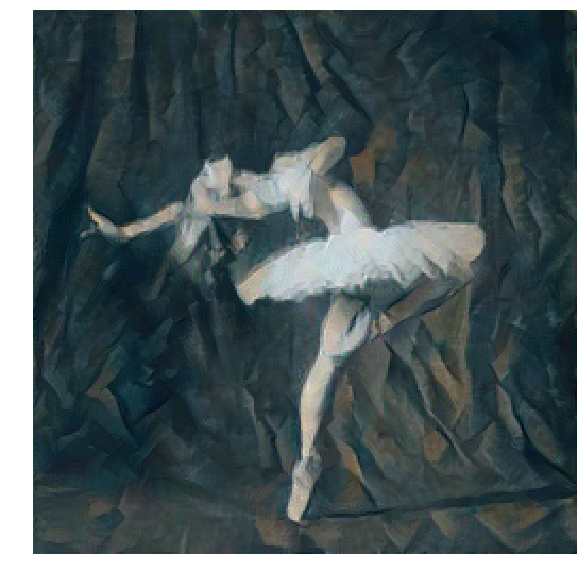

In [4]:
p = style.image.open('etc/dancing.jpg')
a = style.image.open('etc/picasso.jpg')
p = style.image.resize(p, (256,256))
a = style.image.resize(a, (256,256))

# Make sure we all see the same
torch.manual_seed(456)

# choose layers for content and style loss computation
c_id = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,8,12]] = 1

# get a generator object
g = st.iterate(p, a, c_id, style_weights, niter=500, lr=1e-2, x=p);

# and iterate (yields every 50 iterations)
fig, ax = plt.subplots()
img = ax.imshow(np.zeros_like(p))
ax.set_axis_off()

for x, l in g:
    clear_output(wait=True)
    img.set_data(x)
    display(fig)
clear_output(wait=True)



## Multiscale

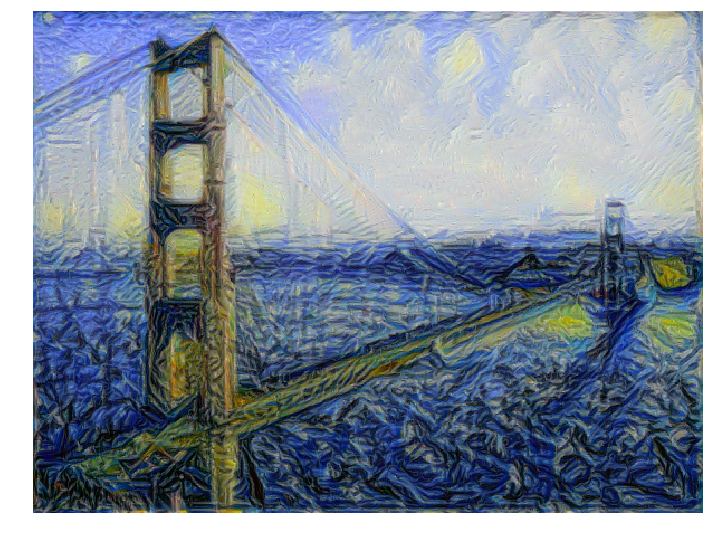

In [5]:
p = style.image.open('etc/bridge.JPG')
a = style.image.open('etc/vangogh.jpg')

sizes = style.image.Pyramid.image_sizes(p.shape, 4)[:-1]
cid = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[2,4,8,12]] = [1, 1, 0.6, 0.2]

imgs = []
for x,_ in st.iterate_multiscale(p, a, cid, style_weights, sizes, x=p, niter=100):
    imgs.append(x)
clear_output(wait=True)

imgs = [style.image.resize(img, sizes[-1]) for img in imgs]
data = np.hstack(imgs)
style.image.save('style.png', data)

plt.imshow(imgs[-1])
plt.axis('off')
plt.show()    

## Seamless

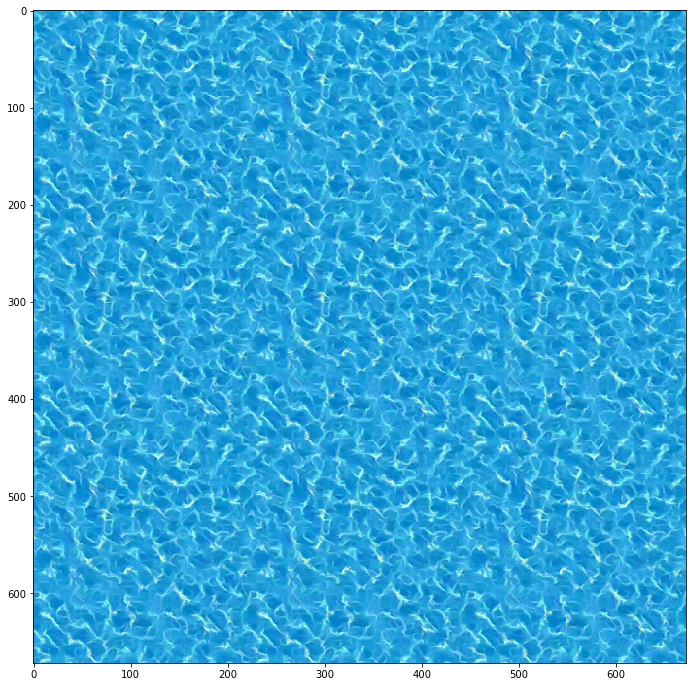

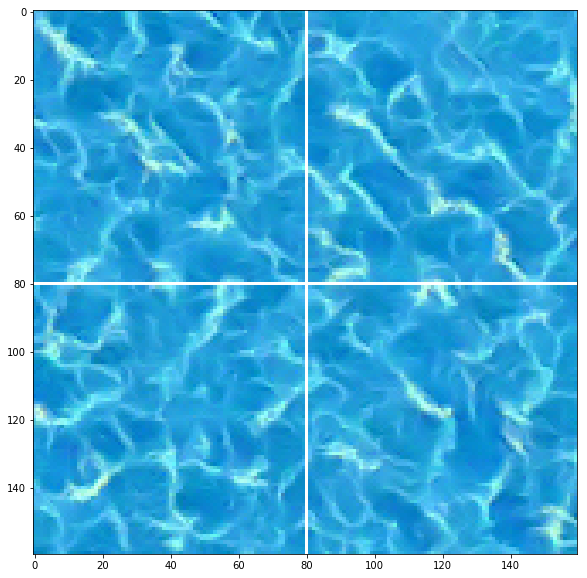

In [10]:
a = style.image.open('etc/water.jpg')
a = style.image.resize(a, (256,256))

np.random.seed(456)
torch.manual_seed(456)

sizes = style.image.Pyramid.image_sizes(a.shape, 3)
cid = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[1,2,4]] = [1]

border = 16
seamless = style.plugins.SeamlessPlugin(a.shape, border)

x,_ = st.run_multiscale(a, a, cid, style_weights, sizes, niter=100, weight_content_loss=0, plugins=[seamless])
x = style.image.borderless_view(x, border)
clear_output(wait=True)

def gen_grid(x, border=True):
    hs = np.hstack((x,x,x))
    vs = np.vstack((hs,hs,hs))

    if border:
        h,w = x.shape[:2]       
        vs[:, [w,2*w]] = 1
        vs[[h,2*h]]=1

    return vs
        

g = gen_grid(x, border=False)
plt.figure(figsize=(12,12))
plt.imshow(g)
plt.show()

gb = gen_grid(x, border=True)
plt.imshow(gb[144:304,144:304])
plt.show()


In [59]:
style.image.save('seamless_border.png', gb)
style.image.save('seamless.png', g)

## Creating larger textures

In [119]:
from style.plugins import Plugin
import copy

class BorderIgnore(Plugin):
    
    def __init__(self, border):
        self.border = border
        
    def after_backward(self, x):
        xnb = style.image.border_elements(x.grad.data, self.border)
        [b.mul_(2) for b in (xnb.t, xnb.tr, xnb.r, xnb.br, xnb.b, xnb.bl, xnb.l, xnb.tl)]
        
    @staticmethod
    def receptive_field(net, dev):
        net = copy.deepcopy(net)    
        
        def init_weights(n):
            if isinstance(n, torch.nn.Conv2d):
                n.weight.data.fill_(1)
                n.bias.data.fill_(0)
        net.apply(init_weights)
    
        x = torch.ones(1,3,256,256).to(dev).requires_grad_()
        y = net(x)
        init_grad = torch.zeros_like(y)
        init_grad[:,:,y.shape[2]//2, y.shape[3]//2] = 1
        y.backward(gradient=init_grad)

        y = style.image.to_np(x.grad)[...,0]
        idxs = np.where(y != 0)
        return [np.max(idx)-np.min(idx)+1 for idx in idxs]


class Tiling:
    
    def __init__(self, st):
        self.st = st
        
    def generate(self, seed, a, c_id, style_weights, grid_shape, border=32, **kwargs):
        final_shape = seed.shape
        tile_shape = (final_shape[0]//grid_shape[0], final_shape[1]//grid_shape[1], 3)
        
 
        seed = np.pad(seed, ((border,border),(border,border),(0,0)), 'reflect')
        unused = np.zeros_like(seed)
        final = np.empty(final_shape, np.float32)
        
        for row in range(grid_shape[0]):
            for col in range(grid_shape[1]):
                
                sr = tile_shape[0] * row
                er = tile_shape[0] * (row+1) + 2*border
                sc = tile_shape[1] * col
                ec = tile_shape[1] * (col+1) + 2*border

                tile,_ = self.st.run(seed[sr:er,sc:ec], a, c_id, style_weights, x=np.array(seed[sr:er,sc:ec]), **kwargs)
                
                sr = tile_shape[0] * row
                er = tile_shape[0] * (row+1)
                sc = tile_shape[1] * col
                ec = tile_shape[1] * (col+1)
                final[sr:er,sc:ec] = style.image.borderless_view(tile, border)
        
        return final
        
        
        

In [56]:
style.image.save('x.png', x)

In [188]:
a = style.image.rotate(style.image.open('etc/picasso.jpg'), 90)
a = style.image.resize(a, (256,256))

cid = st.conv_ids[12]
style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,6]] = [1]


seed = random_start(a, (256,256,3))
x,_ = st.run(seed, a, cid, style_weights, niter=80, weight_content_loss=0, x=seed)

100%|█████████████████████████| 80/80 [00:02<00:00, 30.28it/s, loss=[2.340e-03 0.000e+00 2.339e-03 1.739e-06], lr=0.01]


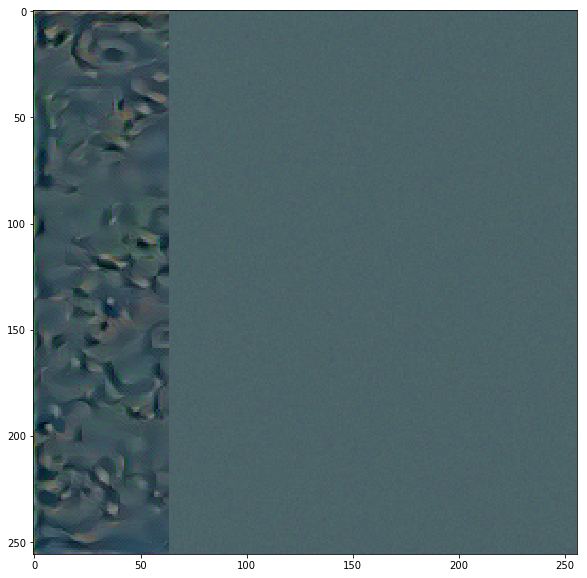

100%|█████████████████████████| 80/80 [00:02<00:00, 30.59it/s, loss=[1.243e-03 0.000e+00 1.241e-03 1.608e-06], lr=0.01]


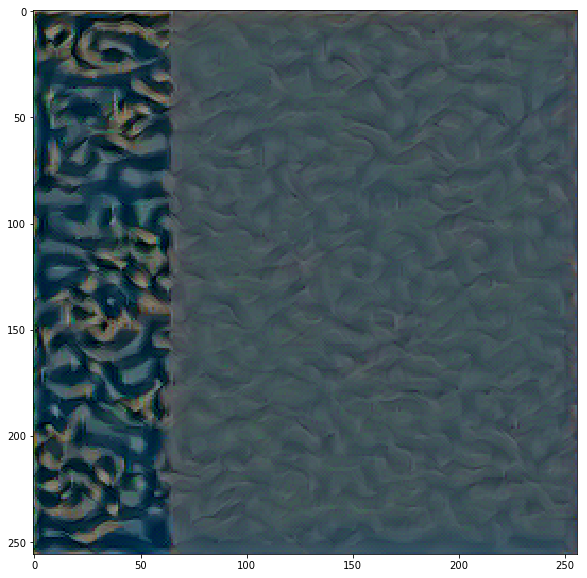

In [193]:
seed = random_start(a, (256,256,3))
seed[:,:64] = x[:,:64]

plt.imshow(seed)
plt.show()

i = seed[:,:64].mean((0,1))
j = seed[:,64:].mean((0,1))

seed[:,:64] *= 1.1


xnew,_ = st.run(seed, a, cid, style_weights, niter=80, weight_content_loss=0,x=seed)

plt.imshow(xnew)
plt.show()

In [178]:
g = style.grid.GridSynthesis(st, (8,8), (128,128,3), s=0, b=32)

100%|████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s, loss=[5.497e-05 0.000e+00 5.348e-05 1.487e-06]]


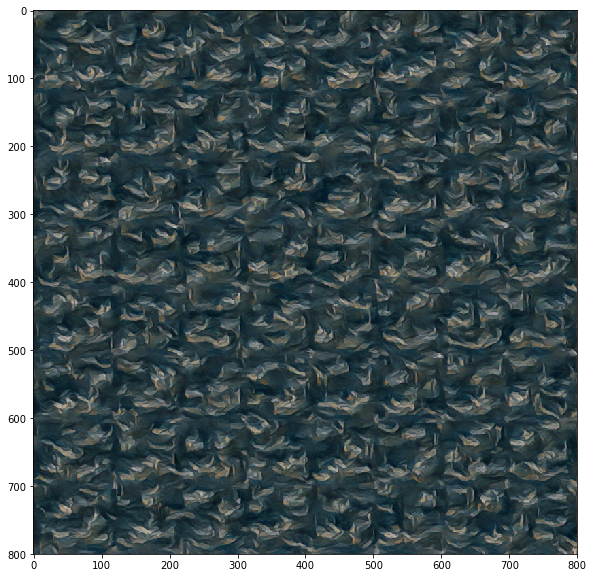

In [179]:
a = style.image.rotate(style.image.open('etc/picasso.jpg'), 90)
a = style.image.resize(a, (128,128))

cid = st.conv_ids[12]
style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,6]] = [1]

x = g.generate(a, c_id, style_weights, multiscale=True, niter=80)

plt.imshow(x)
plt.show()

In [180]:
style.image.save('x.png', x)